In [267]:
# Team member: 
#             Jufeng Yang, ID: 20125011
#             Xingda Zhou, ID: 19107471
#             Zhongen Qin, ID: 19107579

# Import basic libaries: 
# numpy used to pre-process the data and computr the matrix.
# pandas use to import the Train_Test TXT files.
# matplotlib used to plot the figure that shows the result.
import numpy as np
import matplotlib.pyplot as plt

In [268]:
def loadDataSet(fileName):
   #The length of each line
    numberFeat = len(open(fileName).readline().split())-1
    dataSet = []; labelSet = []; dataPosi = []; dataMinus = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        #split esch line
        curLine = line.strip().split()
        # Save data and label of each line
        # Separate the labels and datasets
        for i in range(numberFeat):
            lineArr.append(float(curLine[i]))
        if float(curLine[-1]) > 0:
            dataPosi.append(lineArr)
        else:
            dataMinus.append(lineArr)
        dataSet.append(lineArr)
        labelSet.append(float(curLine[-1]))
    # Convert list to a numpy array
    dataPosi = np.array(dataPosi)
    dataMinus = np.array(dataMinus)
    dataSet = np.array(dataSet)
    labelSet = np.array(labelSet) 
    #return dataSet, labelSet
    return dataPosi, dataMinus, dataSet, labelSet


#new_Fea = []
dataPosi, dataMinus, dataSet, labelSet = loadDataSet('adaboost-train-21.txt')
Fea_Posi_Mean = np.mean(dataPosi, axis = 0)
Fea_Minus_Mean = np.mean(dataMinus, axis = 0)
Vector_of_Mean = Fea_Posi_Mean - Fea_Minus_Mean
Vector_of_dataset = np.subtract(dataSet,Fea_Minus_Mean)  
new_Fea = np.dot(Vector_of_dataset,Vector_of_Mean) / np.linalg.norm(Vector_of_Mean)
weight_posi = np.ones(len(dataPosi)) / len(dataPosi)
weight_posi = np.concatenate((weight_posi, weight_posi), axis = 0)
weight_posi = weight_posi.reshape(2,-1)
print(Fea_Minus_Mean)
print(Vector_of_Mean)
print(new_Fea.shape)
print(dataSet.shape)

[0.00841817 0.01194439]
[0.89363359 0.89600625]
(400,)
(400, 2)


In [269]:
def data_Process(dataPosi, dataMinus, X, y, weight_posi=None, weight_minus=None):
    # Use to store all training positive / minus mean value
    Train_Posi_mean = []
    Train_Minus_mean = []
    
    # All sample values multipy their weights and normalize it.
    # Separately presess positive and negative means
    Fea_Posi_Mean = np.dot(weight_posi, dataPosi)/np.sum(weight_posi)
    Fea_minus_Mean = np.dot(weight_minus, dataMinus)/np.sum(weight_minus)

    # Generate the vector of means 
    # Generate vector of all sample data points
    Vector_of_Mean = Fea_Posi_Mean - Fea_Minus_Mean
    Vector_of_dataset = np.subtract(X,Fea_Minus_Mean)
 
    # Generate new features
    new_Fea = np.dot(Vector_of_dataset,Vector_of_Mean) / np.linalg.norm(Vector_of_Mean)
    
    # Store positive / minus means
    Train_Posi_mean = Fea_Posi_Mean
    Train_Minus_mean = Fea_minus_Mean

    # return new features and means
    return new_Fea, Train_Posi_mean, Train_Minus_mean


# Define a Training method
def weak_learner_fit(dataPosi, dataMinus, X, y, weight_posi=None, weight_minus=None, sample_weight=None):
    # The Minimum error
    best_err = 1
    # The best threshold
    best_thres = 0
    # the sign of threshold, which means, 1 is > threshod, 0 is < threshold.
    best_op = 1
    #self.new_Fea = []
    new_Fea = []
    
    # Initial the weight as 1/n. n is the number of features.
    if sample_weight is None:
        sample_weight = np.ones(len(X)) / len(X)
        weight_posi = np.ones(len(dataPosi)) / len(dataPosi)
        weight_minus = np.ones(len(dataMinus)) / len(dataMinus)
    # Call data_Process() function to convert two features to one feature and return training means.
    new_Fea, Train_Posi_mean, Train_Minus_mean = data_Process(dataPosi, dataMinus,X, y, weight_posi, weight_minus)
    
    # Loop for each feature, and find the best feature to classfy.
    for i in range(1):
        feature = new_Fea
        # Sort the feature value from small to bigger.
        fea_unique = np.sort(np.unique(feature))
        # Loop for computing the error in each medpoint(threshold).  
        for j in range(len(fea_unique)-1):
            # Setting all possible threshold
            thres = (fea_unique[j] + fea_unique[j+1]) / 2 
            for op in (0, 1):
                # Find the better sign: > or <.
                y_ = 2*(feature >= thres)-1 if op==1 else 2*(feature < thres)-1 
                err = np.sum((y_ != y)*sample_weight)
                # Store all parameters when the error is minimum.
                if err < best_err: 
                    best_err = err
                    best_op = op
                    #self.best_fea_id = i
                    best_thres = thres
    # return usefull arrays
    return new_Fea, Train_Posi_mean, Train_Minus_mean, best_err, best_thres, best_op
    
    
# Use the parameter after training to predicte the test points.
# Read the best feature number to predict the test datas.
def weak_learner_predict(new_Fea, best_thres, best_op):
    # Assign new_Fea to variable
    feature = new_Fea
    # Reture the predict result in the range[-1,1]
    return 2*(feature >= best_thres)-1 if best_op == 1 else 2*(feature < best_thres)-1
     
# Use the predict value to calculate accuracy.
# return accuracy of each weak learner 
def weak_learner_accuracy(new_Fea, y, sample_weight=None):
    y_pre = weak_learner_predict(new_Fea)
    if sample_weight is not None:
        return np.sum((y_pre == y)*sample_weight)
    return np.mean(y_pre == y)

In [270]:
# Define a plot merhod. It is used to plot the original data point and weak learner classifier bound.
def showDataSet(featureMat, labelMat,thresholdMat, fea_idMat):
    # Define to array use to store the positive and negative points separately.
    data_plus = []                              
    data_minus = []                             
    
    # Loop for travel throughout all labels 
    # If label is positive, store it into positive array.
    for i in range(len(featureMat)):
        if labelMat[i] > 0:
            data_plus.append(featureMat[i])
        else:
            data_minus.append(featureMat[i])
            
    # Loop for plot the boundary lines
    # feature 1 represent the horizon line. feature 2 represent vertical line.
    for j in range(len(fea_idMat)):
        if fea_idMat[j] > 0:
            plt.axhline(thresholdMat[j])
        else:
            Bound_line = plt.axvline(thresholdMat[j])
    
    # Convert the array into a numpy array, which use to plot scatter. 
    data_plus_np = np.array(data_plus)          
    data_minus_np = np.array(data_minus)        
    
    # Plot the positive and negative points
    Posi_points = plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])
    Naga_Points = plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1])
    plt.legend((Posi_points,Naga_Points,Bound_line),('+1','-1','Boundary'), loc = 'upper right' )
    plt.show()

In [271]:
#Integrated learning adaboost classifier
class AdaBoostClassifier_By_Jufeng:
    def __init__(self, n_estimators=60):
        # Define the number of weak learner.
        # n_estimators use to store the number of weak learner
        # estimators use to store the parameters preduced by Weak_learner
        # New_Fea, Best_op, Train_Posi_mean, Train_Posi_mean use to store parameters used in predict and accuracy function
        # alphas use to store the coefficient of weight.
        # feature_id and threshold use to store the all optimal feature number and threshold
        # use it to plot the graph.
        self.n_estimators = n_estimators
        self.estimators = []
        self.alphas = []
        self.threshold = []
        self.new_Fea = []
        self.best_op = []
        self.Train_Posi_mean = []
        self.Train_Minus_mean = []
        
    def fit(self, dataPosi, dataMinus, X, y):
        # Define some middle variables
        weight_posi = []
        weight_minus = []
        
        # Initial sample weights and positive or minus weights to 1/n
        weight_posi = np.ones(len(dataPosi)) / len(dataPosi)
        weight_minus = np.ones(len(dataMinus)) / len(dataMinus)
        sample_weight = np.ones(len(X)) / len(X)
        
        # Train each weak learners.
        for _ in range(self.n_estimators):
            
            Middle_posi = []
            Middle_minus = []
            # Call the weak classifier.
            new_Fea, Train_Posi_mean, Train_Minus_mean, best_err, best_thres, best_op = weak_learner_fit(dataPosi, 
                                                                                                         dataMinus, 
                                                                                                         X, y, 
                                                                                                         weight_posi, 
                                                                                                         weight_minus, 
                                                                                                         sample_weight)
            # Update the coefficient of the weight
            alpha = 1/2 * np.log((1-best_err)/best_err)
            # Use the weak learner to predict the test data.
            y_pred = weak_learner_predict(new_Fea, best_thres, best_op)
            # Update weights, if misclassification the weight get bigger, use a 1/13 to incease the scale of weight up
            sample_weight *= np.exp(-alpha*y_pred*y)*1/13**(y_pred*y)
            # Normalize the weight.
            sample_weight = sample_weight / np.sum(sample_weight)
            
            for i in range(len(y)):
                # Updata the iteration sample weight, if label is +1, store weight into positive weight array
                if y[i] > 0:
                    Middle_posi = np.append(Middle_posi, sample_weight[i])
                    weight_posi = Middle_posi
                else:
                    Middle_minus = np.append(Middle_minus, sample_weight[i])
                    weight_minus = Middle_minus        

            # Store the coefficient of weight into the alpha variable.
            self.alphas.append(alpha)
            # Store the all optimal thresholds, ops, training positive and minus weight into array 
            self.threshold.append(best_thres)
            self.best_op.append(best_op)
            self.Train_Posi_mean.append(Train_Posi_mean)
            self.Train_Minus_mean.append(Train_Minus_mean)

        return self
     
    # Prediction
    def predict(self, dataSet):
        # Create a array with same size of eatimators number.
        # Define a empty numpy array for vector of means
        # Convert training positive and minus means into numpy array form.
        # Calculate train sample positive or nagative means vector 
        y_pred = np.empty((len(dataSet), self.n_estimators))
        Vector_of_Mean = np.array([])
        self.Train_Posi_mean = np.array(self.Train_Posi_mean)
        self.Train_Minus_mean = np.array(self.Train_Minus_mean)
        Vector_of_Mean = self.Train_Posi_mean - self.Train_Minus_mean
        
        # Calculate all sample point vectors
        # Convert test dataset to new feature form
        for i in range(self.n_estimators):
            Vector_of_dataset = np.subtract(dataSet,self.Train_Minus_mean[i])
            new_Fea = np.dot(Vector_of_dataset,Vector_of_Mean[i]) / np.linalg.norm(Vector_of_Mean[i])
            # Predict result stored in the 2-D array, each colum represent a predict result.
            y_pred[:, i] = weak_learner_predict(new_Fea, self.threshold[i], self.best_op[i])
        # Multiply the prediction result with the training weights as the integrated prediction result
        y_pred = y_pred * np.array(self.alphas)
        # Judged and mapped to -1 and 1 with 0 as the threshold
        return 2*(np.sum(y_pred, axis=1)>0)-1  
   

    # Compare the predict value with ture value.
    # Calculate the accuracy.
    def accuracy(self, dataSet, labelSet):
        y_pred = self.predict(dataSet)
        return np.mean(y_pred==labelSet)

In [272]:
def show_Boundary(dataPosi,dataMinus,Posi_mean, Minus_mean, thres):
    # define a x space
    x = np.arange(-2, 3)
    # Plot  
    for i in range(len(Posi_mean)):
        # Define figure size
        plt.figure(figsize=(5.5,5.5))
        # define the range of x, y axis
        plt.xlim(-2.5,3.5)
        plt.ylim(-2.5,3.5)
        
        # Plot the line of +/-sample means
        plt.plot([Posi_mean[i,0],Minus_mean[i,0]],[Posi_mean[i,1], Minus_mean[i,1]], color='red', linewidth=2.0)
        # Plot the boundary
        k = (Posi_mean[i,1] - Minus_mean[i,1]) / (Posi_mean[i,0] - Minus_mean[i,0])
        b = ((Posi_mean[i,1] - Minus_mean[i,1])/ np.linalg.norm(Posi_mean - Minus_mean))*thres[i]
        y = (-1/k)*x - (-1/k)*Minus_mean[i,0] + Minus_mean[i,1] +  b
        plt.plot(x,y,color='green', linewidth=2.0)
        
        #Plot the sample points
        plt.scatter(dataPosi[:,0],dataPosi[:,1])
        plt.scatter(dataMinus[:,0], dataMinus[:,1])
        plt.title('The origin data points and %d claasifer boundary'%(i+1))
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

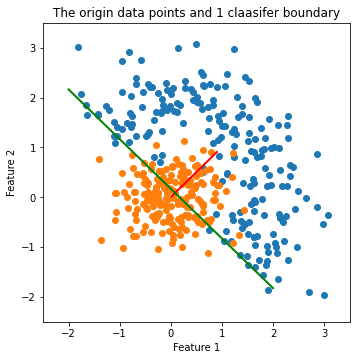

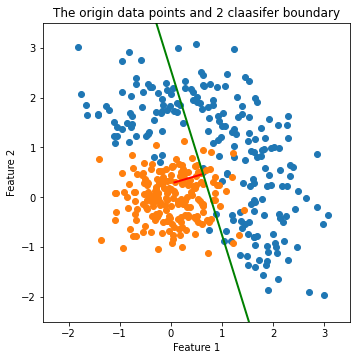

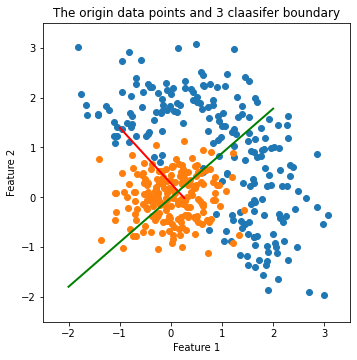

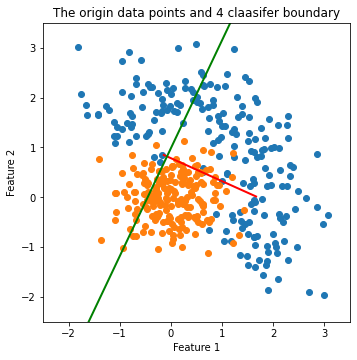

In [273]:
# Load training file
Train_dataPosi, Train_dataMinus,Train_feature, Train_label = loadDataSet('adaboost-train-21.txt')
# Number of esmistor
N = 4
# Call Adaboost and return the positive and nagative means and threshod values
Posi_mean = np.array(AdaBoostClassifier_By_Jufeng(N).fit(Train_dataPosi, Train_dataMinus, Train_feature, Train_label).Train_Posi_mean)
Minus_mean = np.array(AdaBoostClassifier_By_Jufeng(N).fit(Train_dataPosi, Train_dataMinus, Train_feature, Train_label).Train_Minus_mean)
thres = np.array(AdaBoostClassifier_By_Jufeng(N).fit(Train_dataPosi, Train_dataMinus, Train_feature, Train_label).threshold)
# Call show_Boundary function
show_Boundary(Train_dataPosi, Train_dataMinus, Posi_mean, Minus_mean, thres)

1 weak learners, the accuracy is :  0.5
2 weak learners, the accuracy is :  0.825
3 weak learners, the accuracy is :  0.825
4 weak learners, the accuracy is :  0.6125
5 weak learners, the accuracy is :  0.8375
6 weak learners, the accuracy is :  0.6775
7 weak learners, the accuracy is :  0.875
8 weak learners, the accuracy is :  0.74
9 weak learners, the accuracy is :  0.6425
10 weak learners, the accuracy is :  0.585
11 weak learners, the accuracy is :  0.635
12 weak learners, the accuracy is :  0.6275
13 weak learners, the accuracy is :  0.5475
14 weak learners, the accuracy is :  0.56
15 weak learners, the accuracy is :  0.6275
16 weak learners, the accuracy is :  0.575
17 weak learners, the accuracy is :  0.7325
18 weak learners, the accuracy is :  0.7725
19 weak learners, the accuracy is :  0.7275
20 weak learners, the accuracy is :  0.7675
21 weak learners, the accuracy is :  0.8425
22 weak learners, the accuracy is :  0.8275
23 weak learners, the accuracy is :  0.89
24 weak lear

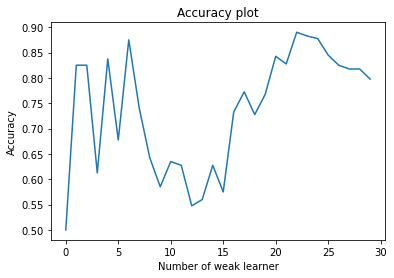

In [274]:
# Define two array to store all numers of accuracy and index(weak learner number)
x = []
Accuracy = []

# Load training and test datasets
Train_dataPosi, Train_dataMinus,Train_feature, Train_label = loadDataSet('adaboost-train-21.txt')
Test_dataPosi, Test_dataMinus,Test_feature, Test_label = loadDataSet('adaboost-test-21.txt')

# Loop for produce the index and accuracys
for n in range(30):
    x.append(n)   
    Accuracy.append(AdaBoostClassifier_By_Jufeng(n).fit(Train_dataPosi, Train_dataMinus, Train_feature, Train_label).accuracy(Train_feature, Train_label))
    print('%d weak learners, the accuracy is : '%(n+1), Accuracy[n])

# Plot the accuracy trend line
plt.title('Accuracy plot')
plt.xlabel('Number of weak learner')
plt.ylabel('Accuracy')
plt.plot(x, Accuracy)
plt.show()